# Send and receive a pulse 

This notebook is based on the [send-receive-pulse demo](../qick_demos/00_Send_receive_pulse.ipynb).

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

# Custom bistream

# QICK
#CUSTOM_BIT = '216/qick_216_orig.bit'
#CUSTOM_BIT = '111_rfbv2/qick_111_rfbv2_orig.bit'

# QICK + ILAs
#CUSTOM_BIT = '216/qick_216_ila.bit'
#CUSTOM_BIT = '111_rfbv2/qick_111_rfbv2_ila.bit'

# QICK + NN + ILAs
CUSTOM_BIT = '216/qick_216.bit'
#CUSTOM_BIT = '111_rfbv2/qick.bit'

# Normalize path
CUSTOM_BIT_FULL_PATH = os.path.normpath(os.getcwd() + '/' + CUSTOM_BIT)

print('Custom bitsream:', CUSTOM_BIT_FULL_PATH)

Custom bitsream: /home/xilinx/jupyter_notebooks/qick/qick_ml/216/qick_216.bit


In [3]:
# Load bitstream with custom overlay
soc = QickSoc(bitfile=CUSTOM_BIT_FULL_PATH)
#soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.199
	Firmware timestamp: Sun Oct  8 19:10:12 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC ti

In [4]:
print('Loaded bitstream:', soccfg.bitfile_name)

Loaded bitstream: /home/xilinx/jupyter_notebooks/qick/qick_ml/216/qick_216.bit


### Hardware Configuration

generator channel 6   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

In [5]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

### Load an excited state

In [6]:
config={"res_ch": 6, # --Fixed
        "ro_chs": [0], # --Fixed
        "reps": 1, # --Fixed
        "relax_delay": 1.0, # --us
        "res_phase": 0, # --degrees
        "pulse_style": "const", # --Fixed

        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs": 100
        # Try varying soft_avgs from 1 to 200 averages        
        
       }

In [7]:
#########################################################
# If you are running Vivado ILA, it is time to arm them #
#########################################################

  0%|          | 0/100 [00:00<?, ?it/s]

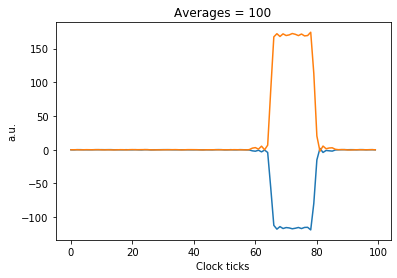

In [8]:
prog =LoopbackProgram(soccfg, config)
    
iq_list = prog.acquire_decimated(soc, progress=True)
    
# Plot results.
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]), color='C0')
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]), color='C1')
    #plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plt.ylabel("a.u.")
    plt.xlabel("Clock ticks")
    plt.title("Averages = " + str(config["soft_avgs"]))
    #plt.legend()
    #plt.show()
plt.savefig("images/send_receive_pulse_const.png", dpi=350)    

In [9]:
import struct
def float_to_hex32(f):
    return format(struct.unpack('!I', struct.pack('!f', f))[0], '08x')

def int_to_twos_complement_hex32(n):
    # If the number is negative, get its two's complement
    if n < 0:
        n = (1 << 32) + n  # "Wrap around" to get 32-bit two's complement
    return format(n, '08x')

# Save trace.
iq = iq_list[0]

# Shows I and Q sequence
iq_sequence = [list(item) for item in zip(*iq)]
iq_sequence = [int(item) for sublist in iq_sequence for item in sublist]

# Float value as hex
#hex_iq_sequence_flt = [float_to_hex32(num) for num in iq_sequence]

# Float -> Int value as hex
#hex_iq_sequence_dec = [int_to_twos_complement_hex32(int(i)) for i in iq_sequence]

print('Sequence length:', len(iq_sequence))
print('I (lo, data[15:0])')
print(iq[0])
print('Q (hi, data[31:16])')
print(iq[1])

print(iq_sequence)

#print(hex_iq_sequence_flt)
#print(hex_iq_sequence_dec)

#for i in range(0,len(iq_sequence),2):
#    print("I {:4.0f} {} {}".format(iq_sequence[i], hex_iq_sequence_flt[i], hex_iq_sequence_dec[i]))
#    print("Q {:4.0f} {} {}".format(iq_sequence[i+1], hex_iq_sequence_flt[i+1], hex_iq_sequence_dec[i+1]))

Sequence length: 200
I (lo, data[15:0])
[-3.0000e-02 -1.6000e-01  1.0000e-01  1.1000e-01 -2.0000e-02 -3.0000e-02
 -6.0000e-02  0.0000e+00  9.0000e-02  7.0000e-02  1.2000e-01  4.0000e-02
  1.2000e-01  1.4000e-01 -5.0000e-02  2.0000e-02 -4.0000e-02 -6.0000e-02
  6.0000e-02 -4.0000e-02 -6.0000e-02  1.0000e-01 -1.0000e-01 -2.0000e-01
  1.1000e-01  5.0000e-02 -2.1000e-01 -1.1000e-01  0.0000e+00  5.0000e-02
  1.1000e-01  1.2000e-01  1.0000e-01 -1.0000e-02 -6.0000e-02 -2.0000e-02
 -5.0000e-02 -2.0000e-02 -1.0000e-02 -6.0000e-02 -8.0000e-02 -1.0000e-02
 -1.0000e-01 -1.9000e-01 -1.0000e-02 -8.0000e-02 -1.4000e-01  7.0000e-02
  2.0000e-01  1.0000e-01 -1.7000e-01 -1.2000e-01  1.0000e-01 -1.4000e-01
 -1.0000e-01  1.5000e-01  3.0000e-02 -1.2000e-01 -2.9000e-01 -1.5900e+00
 -2.1800e+00 -7.2000e-01 -3.1400e+00 -4.5000e-01 -4.0500e+00 -5.6630e+01
 -1.1218e+02 -1.1778e+02 -1.1402e+02 -1.1685e+02 -1.1544e+02 -1.1596e+02
 -1.1724e+02 -1.1643e+02 -1.1531e+02 -1.1691e+02 -1.1523e+02 -1.1506e+02
 -1.1892e+0

In [10]:
from ctypes import *
def to_float(i):
    cp = pointer(c_int(i))
    fp = cast(cp, POINTER(c_float))
    return fp.contents.value

from pynq import MMIO

base_address = 0x00_A013_0000
bram_size = 64

mmio = MMIO(base_address, bram_size)
ground_state_logit = mmio.read(0)
excited_state_logit = mmio.read(4)

if (ground_state_logit > excited_state_logit):
    print("Prediction: ground state")
else:
    print("Prediction: excited state")
print('Logit values as int: [', ground_state_logit, ',', excited_state_logit, ']')
print('Logit values as hex: [', hex(ground_state_logit), ',', hex(excited_state_logit), ']')
print('Logit values as flt: [', to_float(ground_state_logit), ',', to_float(excited_state_logit), ']')

Prediction: excited state
Logit values as int: [ 1065506816 , 3213080576 ]
Logit values as hex: [ 0x3f825800 , 0xbf83b800 ]
Logit values as flt: [ 1.018310546875 , -1.029052734375 ]
